# Projet 5 : Segmentez les comportements de clients
# <u>B. Segmentation des clients</u> <br/>

# Le contexte

Notre employeur Datazon souhaite mieux comprendre le comportements de ses clients afin de faire de meilleures ventes et augmenter son chiffre d'affaire.

Notre **objectif** est de mieux comprendre les clients afin de les classer en catégories et de déterminer automatiquement la catégorie d'un client dès son premier achat.

Ce notebook traite de la partie recherche de segmentation des clients. Nous avons fait de nombreux tests avec différentes features mais nous n'avons garder dans ce notebook que ceux qui ont donnés des résultats intéressants. Exemple de features : catégorie de produit (en fonction du tarif unitaire), min max quantité, score RFM, découpage mensuel, données sur 1 an et 3 derniers mois, ...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import  manifold, cluster
from IPython.display import display

%matplotlib inline

# 1. Importation des données

On charge les données traitées par l'analyse exploratoire.

In [2]:
df= pd.read_csv('orders.csv')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceYear,InvoiceMonth,Canceled,Discount,Promotion,UK,ProductCategory
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,0,0,0,1,3
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,0,0,0,1,3
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,0,0,0,1,3
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,0,0,0,1,3
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,0,0,0,1,3


# 2. Données d'achat par commande

On commence par regrouper les informations de chaque commande

In [4]:
'''
Create from the transactions data a new dataframe containing information group by customer and by invoice
'''
def createDataStructureByOrders(data) :
    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
    o_data = temp.rename(columns = {'TotalPrice':'OrderPrice'})

    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Quantity'].sum()
    o_data.loc[:, 'OrderQuantity'] = temp['Quantity']

    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Canceled'].sum()
    o_data.loc[:, 'OrderCanceled'] = temp['Canceled']

    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Discount'].sum()
    o_data.loc[:, 'OrderDiscount'] = temp['Discount']

    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['Promotion'].sum()
    o_data.loc[:, 'OrderPromo'] = temp['Promotion']


    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['UK'].sum()
    o_data.loc[:, 'isUK'] = temp['UK']

    data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])
    data['InvoiceDate_int'] = data['InvoiceDate'].astype('int64')
    temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
    data.drop('InvoiceDate_int', axis = 1, inplace = True)
    o_data.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
    return o_data

In [5]:
orders_data=createDataStructureByOrders(df)
display(orders_data.head())

,CustomerID,InvoiceNo,OrderPrice,OrderQuantity,OrderCanceled,OrderDiscount,OrderPromo,isUK,InvoiceDate
0,12346.0,541431,77183.60,74215,0,0,0,1,2011-01-18 10:01:00.000000000
1,12346.0,C541433,-77183.60,-74215,1,0,0,1,2011-01-18 10:17:00.000000000
2,12347.0,537626,711.79,319,0,0,0,0,2010-12-07 14:57:00.000001024
3,12347.0,542237,475.39,315,0,0,0,0,2011-01-26 14:29:59.999999744
4,12347.0,549222,636.25,483,0,0,0,0,2011-04-07 10:42:59.999999232


# 3. Séparation temporelle des commandes

## 3.1 Jeu d'entrainement et de test

Pour ne pas biaiser la classification, nous séparons les données en jeu d'entrainement et de tests. Nous allons faire notre clustering sur les données d'entrainement puis appliquer nos modèles d'apprentissage pour la classification. On va ensuite vérifier avec les données de tests.

Nous avons fait un découpage temporel sur les données en regroupant dans le jeu d'entrainement les 9 premiers mois de commandes et la totalité des commandes pour les tests. L'objectif du projet étant de determiner la catégorie du client dès son premier achat, le jeu de test permettra de vérifier la pertinence du modèle séléctionné.

In [6]:
# On prend les données de 9 mois donc jusqu'à la fin Aout 2011
limit = dt.date(2011,9,1)
train_orders = orders_data[orders_data['InvoiceDate'] < limit]
test_orders  = orders_data

In [7]:
print('Nb customers in training set : ', train_orders['CustomerID'].nunique())
print('Nb customers in testing set  : ', test_orders['CustomerID'].nunique())

Nb customers in training set :  3349
Nb customers in testing set  :  4363


## 3.2 Création structure de données par client

Pour chaque client, on construit une structure qui contient les élèments de son panier moyen : 
    - nombre d'achats, total dépensé, dépense panier moyen, quantité de produits, et prix unitaire moyen.

In [8]:
'''
Regroupement des données d'achats par client.
max_date = la date la plus récente des enregistrements nécessaire pour calculer le nombre de jours du dernier achat
'''
def createDataStructureByCustomer(orders_d) :
    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].agg(['count'])
    c_data=temp.rename(columns={'count': 'NbOrders'})
    c_data.reset_index(drop = False, inplace = True)

    temp = orders_d.groupby(by=['CustomerID','InvoiceNo'], as_index=False)['OrderPrice'].sum()
    temp = temp.groupby(by=['CustomerID'])['OrderPrice'].agg(['sum','mean'])
    temp=temp.rename(columns={'sum':'TotalSpent', 'mean':'AverageSpent'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')
    
    # On ne prend que les quantités positives pour la moyenne, le min et max
    temp = orders_d[orders_d.OrderQuantity > 0].groupby(by=['CustomerID','InvoiceNo'], as_index=False)['OrderPrice'].sum()
    temp = temp.groupby(by=['CustomerID'])['OrderPrice'].agg(['min','max'])
    temp=temp.rename(columns={'min':'MinSpent','max':'MaxSpent'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['OrderQuantity'].agg(['sum'])
    temp=temp.rename(columns={'sum': 'TotalQuantity'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['OrderCanceled'].agg(['sum'])
    temp=temp.rename(columns={'sum': 'NbCanceled'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['OrderDiscount'].agg(['sum'])
    temp=temp.rename(columns={'sum': 'NbDiscount'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False)['OrderPromo'].agg(['sum'])
    temp=temp.rename(columns={'sum': 'NbPromo'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    temp = orders_d.groupby(by=['CustomerID'], as_index=False).agg({'isUK': lambda x: 1 if (x.all()>0) else 0})
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')

    dtmax = orders_d.InvoiceDate.max()
    now = dt.datetime(dtmax.year, dtmax.month, dtmax.day) + dt.timedelta(days=1)
    temp = orders_d.groupby('CustomerID').agg({'InvoiceDate': lambda x: (now - x.max()).days})
    temp=temp.rename(columns={'InvoiceDate': 'LastPurchase'})
    temp.reset_index(drop = False, inplace = True)
    c_data=pd.merge(c_data, temp, on='CustomerID', how='outer')
    return c_data

On créé notre structure de données par client à partir du jeu de données d'entrainement'

In [9]:
customers_data = createDataStructureByCustomer(train_orders)

In [10]:
display(customers_data.head())
customers_data.shape

,CustomerID,NbOrders,TotalSpent,AverageSpent,MinSpent,MaxSpent,TotalQuantity,NbCanceled,NbDiscount,NbPromo,isUK,LastPurchase
0,12346.0,2,0.00,0.000,77183.60,77183.60,0,1,0,0,1,225
1,12347.0,5,2790.86,558.172,382.52,711.79,1590,0,0,0,0,29
2,12348.0,3,1167.24,389.080,187.44,652.80,2116,0,0,0,0,148
3,12350.0,1,294.40,294.400,294.40,294.40,196,0,0,0,0,210
4,12352.0,5,521.18,104.236,104.35,296.50,186,7,0,0,0,162


(3349, 12)

## 3.3 Partitionnement des données avec KMeans

### Construction de la matrice données

Commençons par créer une matrice sur laquelle nous pourront appliquer nos algorithmes de clustering

In [11]:
X = customers_data.drop(['CustomerID'], axis=1)

### Utilisation des quantiles pour valoriser les données de chacune des variables

On classe les données en 4 groupes correspondant aux quantiles. Cela facilitera le partionnement en cluster avec des clusters un peu plus homogènes.

- 1 = faible
- 2 = moyen
- 3 = élevé
- 4 = très élevé

In [12]:
'''
méthode permettant d'attribuer un score (entre 1 et 4) à une valeur en fonction d'une colonne en fonction du quantile 
auquel il appartient.
1 premier quantile, ..., 4 dernier quantile.
''' 
def getScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
'''
Calcul score pour les données dont la valorisation est plus importante si la valeur est faible
Ex : LastPurchase. Plus la valeur est petite, plus l'achat est récent donc à une valorisation importante pour nous.
'''
def getRScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [13]:
# Transforme les données en score de quantile et retourne une matrice
def transformAsQuantileMatrix(X) :
    quantiles = X.quantile(q=[0.25,0.5,0.75])
    quantiles = quantiles.to_dict()
    X_std=X.copy()
    for column in X:
        if (column == 'LastPurchase') :
            X_std[column] = X[column].apply(getRScore, args=(column,quantiles,))
        else :
            X_std[column] = X[column].apply(getScore, args=(column,quantiles,))
    return X_std.as_matrix()

In [14]:
X_std = transformAsQuantileMatrix(X)

### Calcul du coefficient de silhouette par cluster

On se limite à chercher au maximum 13 clusters car sinon la segmentation sera trop fine et difficilement utilisable par le service marketing.

In [15]:
'''
Calcul et affichage du coefficient de silhouette pour chaque valeur de k allant de 2 à 13.
'''
def kmeans_silhouette_score(X_std) :
    cluster_range = range( 2, 13 )
    silhouettes = []
     
    # on calcule le score de silhouette pour un nombre de clusters    
    for n_clusters in cluster_range:
        clusterer = KMeans(init='k-means++', n_clusters=n_clusters, n_init=100)
        cluster_labels = clusterer.fit_predict( X_std )
    
        silhouette_avg = silhouette_score(X_std, cluster_labels)
        silhouettes.append(silhouette_avg)
        print("Pour n_clusters =", n_clusters,
            "La moyenne du score de silhouette est : {:<.3f}".format(silhouette_avg))

    # On affiche sous forme de graphe
    plt.step(cluster_range, silhouettes, where='mid',label='cumulative explained variance')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score de silhouette')

    plt.show() 

On applique l'algorithme de KMeans sur nos données. 

Pour n_clusters = 2 La moyenne du score de silhouette est : 0.318
Pour n_clusters = 3 La moyenne du score de silhouette est : 0.291
Pour n_clusters = 4 La moyenne du score de silhouette est : 0.274
Pour n_clusters = 5 La moyenne du score de silhouette est : 0.292
Pour n_clusters = 6 La moyenne du score de silhouette est : 0.280
Pour n_clusters = 7 La moyenne du score de silhouette est : 0.275
Pour n_clusters = 8 La moyenne du score de silhouette est : 0.251
Pour n_clusters = 9 La moyenne du score de silhouette est : 0.259
Pour n_clusters = 10 La moyenne du score de silhouette est : 0.254
Pour n_clusters = 11 La moyenne du score de silhouette est : 0.257
Pour n_clusters = 12 La moyenne du score de silhouette est : 0.254


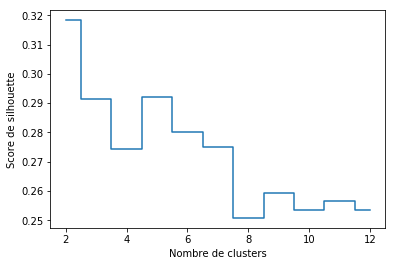

In [16]:
kmeans_silhouette_score(X_std)

- Nous obtenons les meilleurs score à k =2 mais nous voulons au minimum 4 segments pour que ce soit intéressant pour le service marketing. On peut donc partir avec k=5 qui a le 2ème meilleur score ce qui va donner un bon nombre de catégorisation.

Nous partons donc sur 5 clusters et faisons les prédictions de labels avec l'algorithme **Kmeans**.

In [17]:
n_clusters = 5
k_means_cluster = KMeans(init='k-means++', n_clusters=n_clusters, n_init=100)
cluster_labels = k_means_cluster.fit_predict( X_std )

### Silhouette plot

Affichage du score de silhouette intra cluster pour voir si les clusters sont bien homogènes.

In [18]:
def display_silhouette_plot(X_std, cluster_labels):
    sample_silhouette_values = silhouette_samples(X_std, cluster_labels)

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(6, 6)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values,facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    silhouette_avg = silhouette_score(X_std, cluster_labels)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

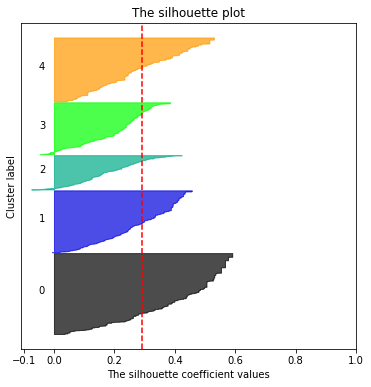

In [19]:
display_silhouette_plot(X_std, cluster_labels)

=> Le resultat est satisfaisant.

### Répartition par nombre de clients

In [20]:
pd.DataFrame(pd.Series(cluster_labels).value_counts(), columns = ['NbCustomers']).sort_values(by='NbCustomers',ascending=False).T

,0,4,1,3,2
NbCustomers,925,731,707,594,392


La répartition est assez équilibrée entre les différents clusters.

### Affichage des clusters

Utilisons TSNE pour afficher les clusters en 2 dimensions.

In [21]:
tsne = manifold.TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(X_std)

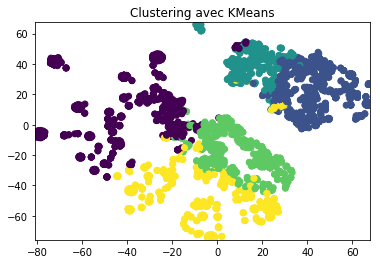

In [22]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels)
plt.xlim([np.min(tsne_results[:, 0]), np.max(tsne_results[:, 0])])
plt.ylim([np.min(tsne_results[:, 1]), np.max(tsne_results[:, 1])])
plt.title('Clustering avec KMeans')

=> Les différents clusters trouvés sont homogènes.

## 3.4 Interprétation des segments

On ajoute les numéros de cluster à notre table

In [23]:
customers_data["Cluster"]= cluster_labels
# Clients par horizon temporel
customers_clusters_TS = pd.DataFrame(X_std)
customers_clusters_TS["Cluster"]= cluster_labels

In [24]:
customers_data.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,3349.0,15284.330845,1725.626611,12346.0,13799.000,15244.000,16771.0000,18287.000
NbOrders,3349.0,4.074351,6.736739,1.0,1.000,2.000,4.0000,133.000
TotalSpent,3349.0,1471.054589,5613.471345,-1192.2,240.680,523.000,1307.3500,175216.540
AverageSpent,3349.0,312.217557,402.417298,-1192.2,143.300,226.240,352.8475,9904.875
MinSpent,3314.0,283.090263,1387.805455,0.0,105.025,182.485,311.4400,77183.600
MaxSpent,3314.0,571.059737,1829.450292,2.9,200.025,332.945,560.1700,77183.600
TotalQuantity,3349.0,871.226635,3444.828602,-1363.0,123.000,290.000,744.0000,126980.000
NbCanceled,3349.0,1.601374,5.240478,0.0,0.000,0.000,1.0000,115.000
NbDiscount,3349.0,0.016124,0.423026,0.0,0.000,0.000,0.0000,23.000
NbPromo,3349.0,0.005972,0.103523,0.0,0.000,0.000,0.0000,4.000


In [25]:
clusters_df = pd.DataFrame()
for i in range(n_clusters):
    mean_data = pd.DataFrame(customers_data[customers_data['Cluster'] == i].mean())
    mean_data = mean_data.T.set_index('Cluster', drop = True)
    mean_data['size'] = customers_data[customers_data['Cluster'] == i].shape[0]
    clusters_df = pd.concat([clusters_df, mean_data])

clusters_df.drop('CustomerID', axis = 1, inplace = True)

clusters_df = clusters_df.sort_values('size')
clusters_df

,NbOrders,TotalSpent,AverageSpent,MinSpent,MaxSpent,TotalQuantity,NbCanceled,NbDiscount,NbPromo,isUK,LastPurchase,size
Cluster,,,,,,,,,,,,
2.0,3.354592,370.688852,104.490823,421.879664,513.795378,199.308673,3.099490,0.000000,0.007653,0.931122,118.719388,392
3.0,4.471380,1854.210438,411.923136,237.455640,634.759091,1150.087542,0.000000,0.000000,0.003367,0.892256,42.979798,594
1.0,10.489392,4349.100014,399.849685,258.426450,1155.818076,2551.598303,5.782178,0.076379,0.018388,0.879774,36.966054,707
4.0,1.251710,582.840807,479.838598,476.062490,511.633584,343.760602,0.046512,0.000000,0.002736,0.861833,126.121751,731
0.0,1.451892,193.492378,136.776334,125.180822,152.273070,109.392432,0.028108,0.000000,0.000000,0.941622,126.375135,925


### Analyse

|         | NbOrders | TotalSpent | AverageSpent |MinSpent | MaxSpent |TotalQuantity | NbCanceled |NbDiscount |NbPromo |isUK |LastPurchase |
|---------|-----------------|-----------------|-----------------|-----------------|-----------------|
|Mediane  |     2         | 523         |         226	    | 182            | 332 |290 | 0 | 0 | 0 | 1 | 72 |

- Cluster 1 (#3) : **clients fidèles** : client qui achètent régulièrement et qui sont actifs on un panier moyen plus élevé que la moyenne. Ce sont aussi ceux qui annulent le plus et ceux qui sont potentiellement intéressés par les remises (discount) et les promotions.
- Cluster 3 (#4) : **clients à haute valeur** : Ils ont le panier moyen le plus élevés et reviennent faire des achats. Ils n'ont pas du tout de commande annulée.
- Cluster 4 (#2) : **clients à potentiel** : clients rares mais qui ont un panier moyen le plus élevé. Mais ils ne sont pas revenus depuis quelques mois et ont fait légerement plus d'un achat sur la plateforme. Ce sont des clients à relancer pour développer les ventes.
- Cluster 2 (#5) : **clients standards** : clients qui ont acheté plusieurs fois mais pas de commandes très élevées et souvent en petite quantité. Ils ne sont pas revenus depuis quelques mois et semblent intéressés par les promos. Ils peuvent aussi potentiellement annuler leurs commandes. Ce sont très largement des clients Anglais.
- Cluster 0 (#1) : **clients à faible valeur ** : ils ont acheté en moyenne moins de 2 fois et ont un panier plus faible que la moyenne et font des achats à faibles montants. Ce sont des client qui ne sont pas revenus depuis au moins 4 mois en moyenne. Ils sont très majoritairement Anglais.




## 3.5 Sauvegarde des données 

Nous regroupons les données d'achats par clients au niveau du jeu de test.

In [26]:
customers_test_TS = createDataStructureByCustomer(test_orders)
display(customers_test_TS.head())

,CustomerID,NbOrders,TotalSpent,AverageSpent,MinSpent,MaxSpent,TotalQuantity,NbCanceled,NbDiscount,NbPromo,isUK,LastPurchase
0,12346.0,2,0.00,0.000000,77183.60,77183.60,0,1,0,0,1,325
1,12347.0,7,4310.00,615.714286,224.82,1294.32,2458,0,0,0,0,2
2,12348.0,4,1437.24,359.310000,187.44,652.80,2332,0,0,0,0,75
3,12349.0,1,1457.55,1457.550000,1457.55,1457.55,630,0,0,0,0,18
4,12350.0,1,294.40,294.400000,294.40,294.40,196,0,0,0,0,310


In [27]:
# Sauvegarde du jeu d'entrainement
customers_clusters_TS.to_csv('customers_clusters_TS.csv', index=False)

In [28]:
# Sauvegarde du jeu de test
test_matrix = transformAsQuantileMatrix(customers_test_TS.drop(['CustomerID'], axis=1))
pd.DataFrame(test_matrix).to_csv('customers_test_TS.csv', index=False)

On sauve aussi l'algorithme kmeans qui a permis de trouver les cluster.

In [29]:
from sklearn.externals import joblib
joblib.dump(k_means_cluster, 'kmeans_cluster_TS.pkl')

['kmeans_cluster_TS.pkl']

# 4. Séparation aléatoire des clients

Pour vérifier la robustesse de notre travail, nous allons essayer maintenant de séparer les données clients en jeu de test et d'entrainement de manière aléatoire (30% / 70%).

## 4.1 Création de la structure

On créé une table clients à partir de toutes les commandes.

In [30]:
all_customers_data = createDataStructureByCustomer(orders_data)

In [31]:
display(all_customers_data.head())
all_customers_data.shape

,CustomerID,NbOrders,TotalSpent,AverageSpent,MinSpent,MaxSpent,TotalQuantity,NbCanceled,NbDiscount,NbPromo,isUK,LastPurchase
0,12346.0,2,0.00,0.000000,77183.60,77183.60,0,1,0,0,1,325
1,12347.0,7,4310.00,615.714286,224.82,1294.32,2458,0,0,0,0,2
2,12348.0,4,1437.24,359.310000,187.44,652.80,2332,0,0,0,0,75
3,12349.0,1,1457.55,1457.550000,1457.55,1457.55,630,0,0,0,0,18
4,12350.0,1,294.40,294.400000,294.40,294.40,196,0,0,0,0,310


(4363, 12)

## 4.2 Jeu d'entrainement et de test

On créé notre jeu d'entrainement et de test (répartition 70/30)

In [32]:
msk = np.random.rand(len(all_customers_data)) < 0.7
train_customers = all_customers_data[msk].copy()
test_customers = all_customers_data[~msk].copy()

In [33]:
print('Nb customers in training set : ', len(train_customers))
print('Nb customers in testing set  : ', len(test_customers))

Nb customers in training set :  3032
Nb customers in testing set  :  1331


## 4.3 Partitionnement des données avec KMeans

### Construction de la matrice données

In [34]:
X = train_customers.drop(['CustomerID'], axis=1)

### Utilisation des quantiles pour valoriser les données de chacune des variables
Même principe que précédement.

In [35]:
X_std = transformAsQuantileMatrix(X)

### Calcul du coefficient de silhouette par cluster

Pour n_clusters = 2 La moyenne du score de silhouette est : 0.316
Pour n_clusters = 3 La moyenne du score de silhouette est : 0.296
Pour n_clusters = 4 La moyenne du score de silhouette est : 0.270
Pour n_clusters = 5 La moyenne du score de silhouette est : 0.283
Pour n_clusters = 6 La moyenne du score de silhouette est : 0.269
Pour n_clusters = 7 La moyenne du score de silhouette est : 0.265
Pour n_clusters = 8 La moyenne du score de silhouette est : 0.245
Pour n_clusters = 9 La moyenne du score de silhouette est : 0.254
Pour n_clusters = 10 La moyenne du score de silhouette est : 0.251
Pour n_clusters = 11 La moyenne du score de silhouette est : 0.248
Pour n_clusters = 12 La moyenne du score de silhouette est : 0.247


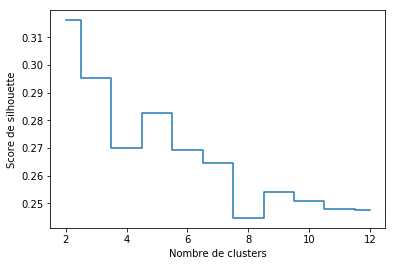

In [36]:
kmeans_silhouette_score(X_std)

On obtient les meilleurs score avec k=2, puis k=3 mais comme on veut au minimum 4 clusters, on choisit k=5 (en plus c'est la même valeur que dans le scénario précent ;-)

Nous partons donc sur 5 clusters et faisons les prédictions de labels avec l'algorithme **Kmeans**.

In [37]:
n_clusters = 5
k_means_cluster = KMeans(init='k-means++', n_clusters=n_clusters, n_init=100)
cluster_labels = k_means_cluster.fit_predict( X_std )

### Silhouette plot

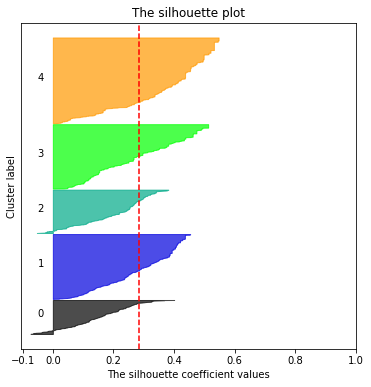

In [38]:
display_silhouette_plot(X_std, cluster_labels)

Tous les clusters ont des valeurs supérieure à la moyenne du coefficient de silhouette. Les clusters sont à peu près équilibrés.

### Répartition par nombre de clients

In [39]:
pd.DataFrame(pd.Series(cluster_labels).value_counts(), columns = ['NbCustomers']).sort_values(by='NbCustomers',ascending=False).T

,4,1,3,2,0
NbCustomers,888,673,668,450,353


### Affichage des clusters

In [40]:
tsne = manifold.TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(X_std)

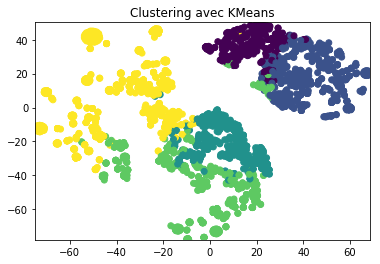

In [41]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels)
plt.xlim([np.min(tsne_results[:, 0]), np.max(tsne_results[:, 0])])
plt.ylim([np.min(tsne_results[:, 1]), np.max(tsne_results[:, 1])])
plt.title('Clustering avec KMeans')

On retrouve globalement des clusters homogènes même si certains points sont éloignés du cluster d'appartenance.

## 4.4 Interprétation des segments

In [42]:
train_customers["Cluster"]= cluster_labels
# Entrainement et tests découpés par client aléatoirement
customers_clusters_Random = pd.DataFrame(X_std)
customers_clusters_Random["Cluster"]= cluster_labels

In [43]:
train_customers.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,3032.0,15256.204815,1715.558825,12346.0,13779.50000,15234.500,16723.5000,18287.000
NbOrders,3032.0,4.950198,9.047357,1.0,1.00000,3.000,5.0000,243.000
TotalSpent,3032.0,1890.307952,8750.319489,-1192.2,288.35000,630.075,1534.9900,278571.620
AverageSpent,3032.0,320.061970,409.380355,-1192.2,151.11375,235.685,361.5600,9904.875
MinSpent,3012.0,273.675432,1448.931167,0.0,98.22750,168.390,306.5250,77183.600
MaxSpent,3012.0,661.698264,3583.023255,15.0,219.27000,360.580,599.6075,168469.600
TotalQuantity,3032.0,1146.279683,5200.896240,-303.0,155.00000,363.000,962.2500,197131.000
NbCanceled,3032.0,2.030673,7.951149,0.0,0.00000,0.000,1.0000,223.000
NbDiscount,3032.0,0.019459,0.650318,0.0,0.00000,0.000,0.0000,35.000
NbPromo,3032.0,0.008245,0.131977,0.0,0.00000,0.000,0.0000,4.000


In [44]:
clusters_df = pd.DataFrame()
for i in range(n_clusters):
    mean_data = pd.DataFrame(train_customers[train_customers['Cluster'] == i].mean())
    mean_data = mean_data.T.set_index('Cluster', drop = True)
    mean_data['size'] = train_customers[train_customers['Cluster'] == i].shape[0]
    clusters_df = pd.concat([clusters_df, mean_data])

clusters_df.drop('CustomerID', axis = 1, inplace = True)

clusters_df = clusters_df.sort_values('size')
clusters_df

,NbOrders,TotalSpent,AverageSpent,MinSpent,MaxSpent,TotalQuantity,NbCanceled,NbDiscount,NbPromo,isUK,LastPurchase,size
Cluster,,,,,,,,,,,,
0.0,3.660057,446.063711,114.443959,437.337628,1058.760180,282.220963,3.342776,0.005666,0.008499,0.903683,118.898017,353
2.0,5.426667,2512.452289,391.203969,177.592022,710.726978,1425.148889,0.000000,0.000000,0.002222,0.902222,34.053333,450
3.0,1.568862,862.307545,556.375666,519.807186,669.996243,504.220060,0.103293,0.000000,0.001497,0.872754,116.976048,668
1.0,13.096582,5434.607400,362.581830,192.127935,1065.432199,3357.264487,7.286776,0.084695,0.029718,0.895988,27.369985,673
4.0,1.591216,236.303457,155.755487,137.643311,175.729200,155.766892,0.004505,0.000000,0.000000,0.942568,135.308559,888


### Analyse

|         | NbOrders | TotalSpent | AverageSpent |MinSpent | MaxSpent |TotalQuantity | NbCanceled |NbDiscount |NbPromo |isUK |LastPurchase |
|---------|-----------------|-----------------|-----------------|-----------------|-----------------|
|Mediane  |     3         | 630         |         235    | 168            | 360 |363 | 0 | 0 | 0 | 1 | 48 |

- Cluster 1 (#2) : **clients fidèles** : ont achetés régulièrement et plus que la moyenne.
- Cluster 2 (#4) : **clients à haute valeur** : Ils ont un panier moyen élevé et ils reviennent faire des achats. 
- Cluster 3 (#3) : **clients à potentiel** : clients rares mais qui ont un panier moyen très élevé. 
- Cluster 4 (#5) : **clients standards** : clients qui ont acheté plusieurs fois mais pas de commandes très élevées.
- Cluster 0 (#1) : **clients à faible valeur ** : ils ont de petits paniers d'achats et ne sont pas revenus pour la plupart.

=> Nous arrivons à trouver les mêmes interprétations que dans le cas précédent.

## 4.5 Sauvegarde des données 

On sauvegarde les données pour les utiliser ensuite dans nos tests de modèles de classification

In [53]:
# Sauvegarde du jeu d'entrainement
customers_clusters_Random.to_csv('customers_clusters_Random.csv', index=False)

In [46]:
# Sauvegarde du jeu de test
test_matrix = transformAsQuantileMatrix(test_customers.drop(['CustomerID'], axis=1))
pd.DataFrame(test_matrix).to_csv('customers_test_Random.csv', index=False)

In [47]:
joblib.dump(k_means_cluster, 'kmeans_cluster_Random.pkl')

['kmeans_cluster_Random.pkl']